In [17]:
import numpy as np
import pandas as pd
from google.colab import drive

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve
)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, regularizers
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC, Precision, Recall
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, BatchNormalization, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from sklearn.utils import class_weight

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
stock_data = pd.read_csv("/content/drive/MyDrive/final_data.csv")
stock_data  = stock_data [stock_data ['date'].between('2009-01-01', '2024-12-31')]

In [24]:
extra_data = pd.read_csv("/content/drive/MyDrive/extra_factor.csv",index_col=0)

In [25]:
stock_data = pd.concat([stock_data,extra_data],axis = 1)

In [26]:
id_col = ["PERMNO", 'CUSIP', 'Ticker', 'SICCD','NAICS']
time_col = ['MthCalDt']
factor_col = ['mom_12','mom_6', 'vol_12', 'vol_6', 'rev_1', 'rvol_1',"rsi_6", 'trend_strength']+extra_data.columns.tolist()
market_col = [ 'qmj_safety','seas_11_15na',
              'ret_3_1', 'iskew_ff3_21d', 'rskew_21d', 'sti_gr1a','earnings_variability', 'nfna_gr1a',
              'seas_16_20an', 'corr_1260d']
fin_col = ['capxy', 'chechy', 'cshfdy', 'cshpry', 'dltry', 'dpcy',
       'epspxy', 'oibdpy', 'txty']

In [27]:
scaler_factor = StandardScaler()
stock_data[factor_col] = scaler_factor.fit_transform(stock_data[factor_col ])

scaler_fin = StandardScaler()
stock_data[fin_col] = scaler_fin.fit_transform(stock_data[fin_col ])

scaler_market = StandardScaler()
stock_data[market_col] = scaler_market.fit_transform(stock_data[market_col ])

In [28]:
train_set = stock_data[stock_data["year"] <= 2021]
vol_set = train_set[train_set["year"]>2018]
train_set = train_set[train_set["year"]<=2018]
test_set = stock_data[stock_data["year"]>2021]

In [29]:
ml_col = factor_col+fin_col+market_col+["Quarter", "naics", "ind_1"]

In [30]:
X_train = train_set[ml_col]
y_train = train_set["pred_cat"]
X_val = vol_set[ml_col]
y_val = vol_set["pred_cat"]
X_test = test_set[ml_col]
y_test = test_set["pred_cat"]

In [34]:
N_COMPUSTAT_FEATURES = len(fin_col)
N_RETURN_FEATURES = len(factor_col)
N_CLASSES = 1
X_compustat_train, X_returns_train, X_embeddings_train = X_train[fin_col], X_train[factor_col], X_train[market_col+["Quarter","naics", "ind_1"]]
X_compustat_val, X_returns_val, X_embeddings_val = X_val[fin_col], X_val[factor_col], X_val[market_col+["Quarter","naics", "ind_1"]]
X_compustat_test, X_returns_test, X_embeddings_test = X_test[fin_col], X_test[factor_col], X_test[market_col+["Quarter","naics", "ind_1"]]

N_EMBEDDING_FEATURES = len(market_col+["Quarter","naics", "ind_1"])

In [32]:
def build_multi_input_model(n_embedding_features, use_compustat=True, use_returns=True, use_reports=True,):
    # Input A: Compustat Factors Branch
    input_compustat = Input(shape=(N_COMPUSTAT_FEATURES,), name='compustat_input')
    x1 = Dense(64, activation='relu')(input_compustat)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(0.3)(x1)
    x1 = Dense(32, activation='relu')(x1)

    # Input B: Cumulative Returns Branch

    # Simple Dense layer
    # input_returns = Input(shape=(N_RETURN_FEATURES,), name='returns_input')
    # x2 = Dense(32, activation='relu')(input_returns)
    # x2 = BatchNormalization()(x2)
    # x2 = Dropout(0.3)(x2)
    # x2 = Dense(16, activation='relu')(x2)

    input_returns = Input(shape=(N_RETURN_FEATURES, 1), name='returns_input')
    # 1D Convolutional layer to find temporal patterns
    x2 = Conv1D(filters=32, kernel_size=2, activation='relu')(input_returns)
    x2 = GlobalMaxPooling1D()(x2)
    x2 = Dropout(0.3)(x2)

    # Input C: Textual Embeddings Branch
    input_embeddings = Input(shape=(n_embedding_features,), name='embedding_input')
    x3 = Dense(128, activation='relu')(input_embeddings)
    x3 = BatchNormalization()(x3)
    x3 = Dropout(0.5)(x3)
    x3 = Dense(64, activation='relu')(x3)

    # Concatenate the outputs of the three branches
    if use_compustat and use_returns and use_reports:
        combined = Concatenate()([x1, x2, x3])
    elif use_compustat and use_returns:
        combined = Concatenate()([x1, x2])
    elif use_compustat and use_reports:
        combined = Concatenate()([x1, x3])
    elif use_returns and use_reports:
        combined = Concatenate()([x2, x3])
    elif use_compustat:
        combined = x1
    elif use_returns:
        combined = x2
    elif use_reports:
        combined = x3

    # Final prediction head
    z = Dense(64, activation='relu')(combined)
    z = Dropout(0.5)(z)
    z = Dense(32, activation='relu')(z)

    # Output layer for binary classification
    output_layer = Dense(N_CLASSES, activation='sigmoid', name='output')(z)

    # Build and compile the model
    model = Model(inputs=[input_compustat, input_returns, input_embeddings], outputs=output_layer)

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [35]:
model = build_multi_input_model(N_EMBEDDING_FEATURES, True, True, True)
model.summary()

# Define EarlyStopping callback
early_stopping = dnn_callbacks = [
    callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(patience=5, factor=0.5),
    callbacks.ModelCheckpoint('best_dnn_model.h5', save_best_only=True)
]

all_possible_classes = np.array([0, 1])

# Balance the training dataset
class_weights = class_weight.compute_class_weight(
    class_weight = "balanced",
    classes = all_possible_classes,
    y = np.ravel(y_train)
)

class_weight_dict = dict(enumerate(class_weights))

print(class_weight_dict)

history = model.fit(
    [X_compustat_train, X_returns_train, X_embeddings_train],
    y_train,
    validation_data=([X_compustat_val, X_returns_val, X_embeddings_val], y_val),
    epochs=50,
    batch_size=256,
    callbacks=[early_stopping],
    class_weight=class_weight_dict
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ compustat_input     │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_input     │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 64)        │        640 │ compustat_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ returns_input       │ (None, 41, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 128)       │      1,792 │ embedding_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_18[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 40, 32)    │         96 │ returns_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_20[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 64)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv1d_3[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 32)        │      2,080 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 32)        │          0 │ global_max_pooli… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 64)        │      8,256 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 128)       │          0 │ dense_19[0][0],   │
│ (Concatenate)       │                   │            │ dropout_13[0][0], │
│                     │                   │            │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 64)        │      8,256 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 64)        │          0 │ dense_22[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 32)        │      2,080 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         33 │ dense_23[0][0]  

 Total params: 24,001 (93.75 KB)

 Trainable params: 23,617 (92.25 KB)

 Non-trainable params: 384 (1.50 KB)

{0: np.float64(1.1085311399759703), 1: np.float64(0.9108253194896024)}
Epoch 1/50
2898/2898 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5631 - loss: 0.6844

2898/2898 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.5631 - loss: 0.6844 - val_accuracy: 0.6388 - val_loss: 0.6482 - learning_rate: 0.0010
Epoch 2/50
2893/2898 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5870 - loss: 0.6679

2898/2898 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5870 - loss: 0.6679 - val_accuracy: 0.6334 - val_loss: 0.6442 - learning_rate: 0.0010
Epoch 3/50
2886/2898 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5901 - loss: 0.6661

2898/2898 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5901 - loss: 0.6661 - val_accuracy: 0.6330 - val_loss: 0.6432 - learning_rate: 0.0010
Epoch 4/50
2898/2898 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5932 - loss: 0.6640 - val_accuracy: 0.6189 - val_loss: 0.6442 - learning_rate: 0.0010
Epoch 5/50
2890/2898 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5924 - loss: 0.6626

2898/2898 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5924 - loss: 0.6626 - val_accuracy: 0.6345 - val_loss: 0.6374 - learning_rate: 0.0010
Epoch 6/50
2898/2898 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5971 - loss: 0.6615 - val_accuracy: 0.6271 - val_loss: 0.6406 - learning_rate: 0.0010
Epoch 7/50
2898/2898 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5973 - loss: 0.6610 - val_accuracy: 0.6318 - val_loss: 0.6386 - learning_rate: 0.0010
Epoch 8/50
2898/2898 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5971 - loss: 0.6605 - val_accuracy: 0.6236 - val_loss: 0.6404 - learning_rate: 0.0010
Epoch 9/50
2898/2898 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5973 - loss: 0.6601 - val_accuracy: 0.6239 - val_loss: 0.6424 - learning_rate: 0.0010
Epoch 10/50
2898/2898 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5983 - loss: 0.6602 - val_accuracy: 0.6283 - val_loss: 0.6392 - learning_rate: 0.0010
Epoch 11/50
2898/2898 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5992 - los

In [38]:
test_loss, test_accuracy = model.evaluate(
    [X_compustat_test, X_returns_test, X_embeddings_test],
    y_test
)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

9043/9043 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.6952 - loss: 0.6010

Test Accuracy: 0.6957
Test Loss: 0.6019


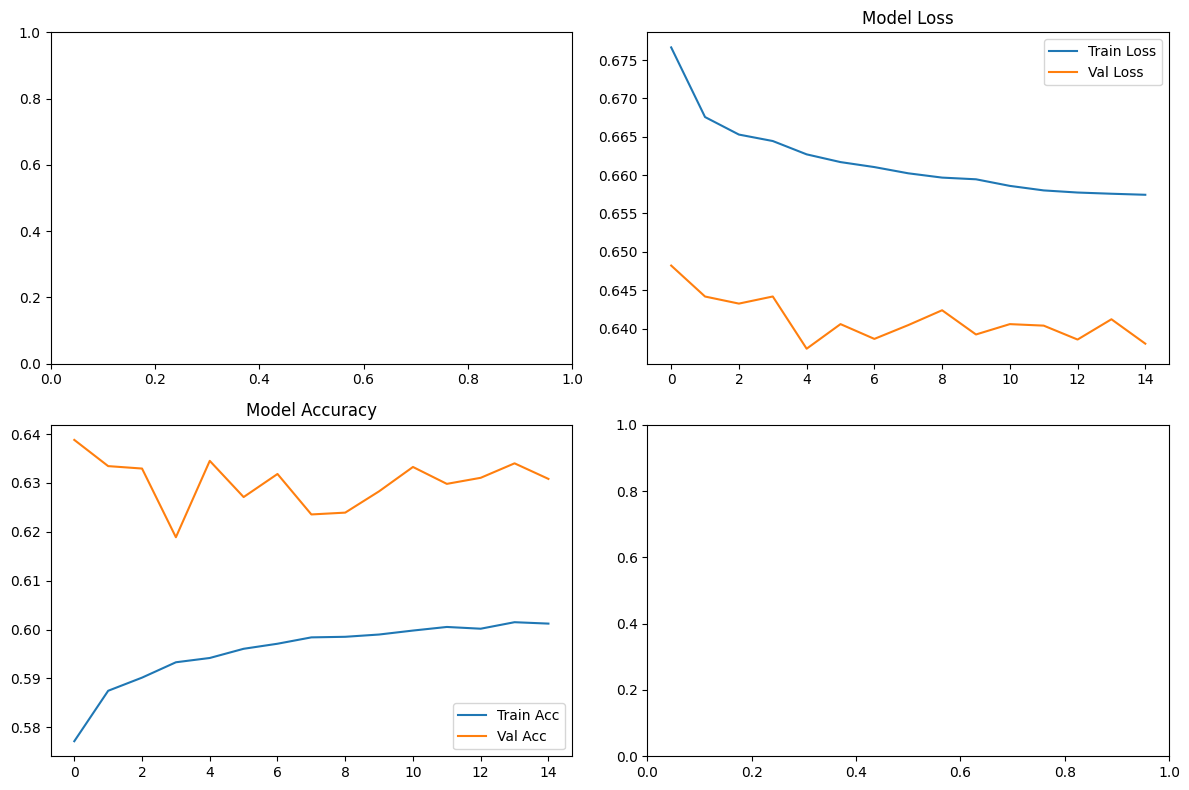

<Figure size 640x480 with 0 Axes>

In [37]:
import matplotlib.pyplot as plt

def plot_training_history(history):

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    if "auc" in history.history:
      axes[0,0].plot(history.history['auc'], label='Train AUC')
      axes[0,0].plot(history.history['val_auc'], label='Val AUC')
      axes[0,0].set_title('Model AUC')
      axes[0,0].legend()

    axes[0,1].plot(history.history['loss'], label='Train Loss')
    axes[0,1].plot(history.history['val_loss'], label='Val Loss')
    axes[0,1].set_title('Model Loss')
    axes[0,1].legend()

    axes[1,0].plot(history.history['accuracy'], label='Train Acc')
    axes[1,0].plot(history.history['val_accuracy'], label='Val Acc')
    axes[1,0].set_title('Model Accuracy')
    axes[1,0].legend()

    if "precision" in history.history:
      axes[1,1].plot(history.history['precision'], label='Train Precision')
      axes[1,1].plot(history.history['val_precision'], label='Val Precision')
      axes[1,1].set_title('Model Precision')
      axes[1,1].legend()

    if 'lr' in history.history:
        axes[1,1].plot(history.history['lr'])
        axes[1,1].set_title('Learning Rate')
        axes[1,1].set_yscale('log')

    plt.tight_layout()
    plt.show()
    plt.savefig("DNN.jpg")

plot_training_history(history)